# 第35章: PyTorch基礎と勾配降下法

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] PyTorchのテンソル操作を使いこなせる
- [ ] 自動微分（Autograd）の仕組みを理解できる
- [ ] 勾配降下法を実装できる
- [ ] PyTorchでニューラルネットワークを構築できる
- [ ] VAE実装の準備ができる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Notebook 34（EMアルゴリズム、ELBO）
- ✅ NumPyの基本操作
- ✅ 微分の基礎

⏱️ **推定学習時間**: 120-150分  
📊 **難易度**: ★★★☆☆（中級）  
🎓 **カテゴリ**: 実践

---

## 🌟 はじめに

前章まででEMアルゴリズムとELBOを学びました。VAE（変分オートエンコーダ）は、このELBOをニューラルネットワークで最適化するモデルです。

VAEを実装するには、**PyTorch**というディープラーニングフレームワークを使います。

### 🤔 なぜPyTorchなのか？

1. **自動微分**: 複雑な計算グラフでも勾配を自動計算
2. **GPU対応**: 大規模な行列演算を高速化
3. **柔軟性**: 研究から実用まで幅広く使える
4. **コミュニティ**: 豊富なドキュメントとサンプルコード

この章では、VAE実装に必要なPyTorchの基礎を学びます。

In [1]:
# ============================================================
# 環境設定
# PyTorchと必要なライブラリをインポートします
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# PyTorchのインポート
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 警告を非表示
warnings.filterwarnings('ignore')

# グラフスタイルの設定
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',
        'Yu Gothic', 'MS Gothic',
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"日本語フォント: {font_used}")

# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 'cpu')

# 再現性のための乱数シード
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print("✅ ライブラリのインポート完了")

日本語フォント: Hiragino Sans
PyTorch version: 2.9.1
Device: mps
✅ ライブラリのインポート完了


---

## 1. テンソル（Tensor）の基礎

### 🤔 テンソルとは？

**テンソル**は、NumPyの配列（ndarray）に相当するPyTorchの基本データ構造です。

| NumPy | PyTorch | 説明 |
|-------|---------|------|
| `np.array` | `torch.tensor` | 配列の作成 |
| `ndarray` | `Tensor` | データ型 |
| `.shape` | `.shape` | サイズ |
| `.dtype` | `.dtype` | データ型 |

### 📊 NumPyとの主な違い

1. **GPU対応**: テンソルはGPU上で計算できる
2. **自動微分**: 勾配を自動的に計算できる
3. **計算グラフ**: 演算の履歴を記録

In [2]:
# ============================================================
# テンソルの基本操作
# テンソルの作成と基本的な操作を学びます
# ============================================================

print("="*60)
print("1. テンソルの作成")
print("="*60)

# 方法1: リストから作成
t1 = torch.tensor([1, 2, 3, 4, 5])
print(f"\nリストから: {t1}")
print(f"  shape: {t1.shape}, dtype: {t1.dtype}")

# 方法2: NumPy配列から作成
np_array = np.array([[1.0, 2.0], [3.0, 4.0]])
t2 = torch.from_numpy(np_array)
print(f"\nNumPyから: \n{t2}")
print(f"  shape: {t2.shape}, dtype: {t2.dtype}")

# 方法3: 特殊なテンソル
t_zeros = torch.zeros(2, 3)  # 全て0
t_ones = torch.ones(2, 3)    # 全て1
t_rand = torch.rand(2, 3)    # 0~1の一様乱数
t_randn = torch.randn(2, 3)  # 標準正規分布

print(f"\nzeros(2,3): \n{t_zeros}")
print(f"\nrandn(2,3): \n{t_randn}")

# 方法4: 既存テンソルと同じ形状
t_like = torch.zeros_like(t_randn)
print(f"\nzeros_like: \n{t_like}")

1. テンソルの作成

リストから: tensor([1, 2, 3, 4, 5])
  shape: torch.Size([5]), dtype: torch.int64

NumPyから: 
tensor([[1., 2.],
        [3., 4.]], dtype=torch.float64)
  shape: torch.Size([2, 2]), dtype: torch.float64

zeros(2,3): 
tensor([[0., 0., 0.],
        [0., 0., 0.]])

randn(2,3): 
tensor([[ 1.1561,  0.3965, -2.4661],
        [ 0.3623,  0.3765, -0.1808]])

zeros_like: 
tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [3]:
# ============================================================
# テンソルの演算
# 基本的な数学演算を学びます
# ============================================================

print("="*60)
print("2. テンソルの演算")
print("="*60)

# 2つのテンソルを作成
a = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
b = torch.tensor([[5.0, 6.0], [7.0, 8.0]])

print(f"a = \n{a}")
print(f"\nb = \n{b}")

# 要素ごとの演算
print(f"\n--- 要素ごとの演算 ---")
print(f"a + b = \n{a + b}")
print(f"a * b = \n{a * b}")
print(f"a ** 2 = \n{a ** 2}")

# 行列演算
print(f"\n--- 行列演算 ---")
print(f"a @ b (行列積) = \n{a @ b}")
print(f"a.T (転置) = \n{a.T}")

# 集約演算
print(f"\n--- 集約演算 ---")
print(f"a.sum() = {a.sum()}")
print(f"a.mean() = {a.mean()}")
print(f"a.sum(dim=0) (列方向) = {a.sum(dim=0)}")
print(f"a.sum(dim=1) (行方向) = {a.sum(dim=1)}")

2. テンソルの演算
a = 
tensor([[1., 2.],
        [3., 4.]])

b = 
tensor([[5., 6.],
        [7., 8.]])

--- 要素ごとの演算 ---
a + b = 
tensor([[ 6.,  8.],
        [10., 12.]])
a * b = 
tensor([[ 5., 12.],
        [21., 32.]])
a ** 2 = 
tensor([[ 1.,  4.],
        [ 9., 16.]])

--- 行列演算 ---
a @ b (行列積) = 
tensor([[19., 22.],
        [43., 50.]])
a.T (転置) = 
tensor([[1., 3.],
        [2., 4.]])

--- 集約演算 ---
a.sum() = 10.0
a.mean() = 2.5
a.sum(dim=0) (列方向) = tensor([4., 6.])
a.sum(dim=1) (行方向) = tensor([3., 7.])


In [4]:
# ============================================================
# テンソルの形状変更
# reshape, view, squeeze, unsqueezeを学びます
# ============================================================

print("="*60)
print("3. テンソルの形状変更")
print("="*60)

# 元のテンソル
x = torch.arange(12)  # [0, 1, 2, ..., 11]
print(f"\n元のテンソル: {x}")
print(f"shape: {x.shape}")

# reshape / view
x_reshaped = x.view(3, 4)  # 3行4列に変形
print(f"\nview(3, 4):\n{x_reshaped}")

x_reshaped2 = x.view(2, 2, 3)  # 2x2x3に変形
print(f"\nview(2, 2, 3):\n{x_reshaped2}")

# -1 を使った自動計算
x_auto = x.view(4, -1)  # 4行、列は自動計算
print(f"\nview(4, -1):\n{x_auto}")

# unsqueeze: 次元を追加
y = torch.tensor([1, 2, 3])
print(f"\n元: {y.shape}")
print(f"unsqueeze(0): {y.unsqueeze(0).shape}")
print(f"unsqueeze(1): {y.unsqueeze(1).shape}")

# squeeze: サイズ1の次元を削除
z = torch.zeros(1, 3, 1, 4)
print(f"\n元: {z.shape}")
print(f"squeeze(): {z.squeeze().shape}")

3. テンソルの形状変更

元のテンソル: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
shape: torch.Size([12])

view(3, 4):
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

view(2, 2, 3):
tensor([[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 6,  7,  8],
         [ 9, 10, 11]]])

view(4, -1):
tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])

元: torch.Size([3])
unsqueeze(0): torch.Size([1, 3])
unsqueeze(1): torch.Size([3, 1])

元: torch.Size([1, 3, 1, 4])
squeeze(): torch.Size([3, 4])


---

## 2. 自動微分（Autograd）

### 🤔 自動微分とは？

PyTorchの**Autograd**は、テンソルに対する演算の勾配を自動的に計算する仕組みです。

これにより、複雑なニューラルネットワークでも、手動で勾配を計算する必要がありません。

### 📊 基本的な仕組み

1. `requires_grad=True`のテンソルを作成
2. そのテンソルに対して演算を行う
3. 結果に対して`.backward()`を呼び出す
4. 各テンソルの`.grad`属性に勾配が格納される

In [5]:
# ============================================================
# 自動微分の基本
# 簡単な例で自動微分を理解します
# ============================================================

print("="*60)
print("自動微分の基本")
print("="*60)

# 例1: y = x^2 の微分（dy/dx = 2x）
print("\n【例1】y = x² の微分")

x = torch.tensor(3.0, requires_grad=True)
y = x ** 2

print(f"x = {x}")
print(f"y = x² = {y}")

# 勾配を計算
y.backward()

print(f"dy/dx = {x.grad}")
print(f"（期待値: 2x = 2*3 = 6）")

自動微分の基本

【例1】y = x² の微分
x = 3.0
y = x² = 9.0
dy/dx = 6.0
（期待値: 2x = 2*3 = 6）


In [6]:
# ============================================================
# 複雑な計算グラフでの自動微分
# 連鎖律が自動的に適用されることを確認します
# ============================================================

print("="*60)
print("複雑な計算グラフ")
print("="*60)

# 例2: z = (x + y)^2 の微分
print("\n【例2】z = (x + y)² の微分")

x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)

# 計算グラフを構築
u = x + y
z = u ** 2

print(f"x = {x.item()}, y = {y.item()}")
print(f"u = x + y = {u.item()}")
print(f"z = u² = {z.item()}")

# 勾配を計算
z.backward()

print(f"\ndz/dx = {x.grad.item()}")
print(f"dz/dy = {y.grad.item()}")
print("\n（期待値: dz/dx = dz/dy = 2u = 2(x+y) = 2*5 = 10）")

複雑な計算グラフ

【例2】z = (x + y)² の微分
x = 2.0, y = 3.0
u = x + y = 5.0
z = u² = 25.0

dz/dx = 10.0
dz/dy = 10.0

（期待値: dz/dx = dz/dy = 2u = 2(x+y) = 2*5 = 10）


In [7]:
# ============================================================
# ベクトル・行列の自動微分
# 高次元テンソルでの勾配計算を学びます
# ============================================================

print("="*60)
print("ベクトル・行列の自動微分")
print("="*60)

# 例3: L = sum(Wx + b)^2 の微分
print("\n【例3】線形変換 + 二乗和")

# パラメータ
W = torch.randn(3, 2, requires_grad=True)
b = torch.randn(3, requires_grad=True)

# 入力
x = torch.randn(2)

# 順伝播
y = W @ x + b
L = (y ** 2).sum()  # 損失関数（スカラー）

print(f"W.shape = {W.shape}")
print(f"x.shape = {x.shape}")
print(f"y.shape = {y.shape}")
print(f"L = {L.item():.4f}")

# 勾配を計算
L.backward()

print(f"\ndL/dW.shape = {W.grad.shape}")
print(f"dL/db.shape = {b.grad.shape}")
print(f"\ndL/dW = \n{W.grad}")
print(f"\ndL/db = {b.grad}")

ベクトル・行列の自動微分

【例3】線形変換 + 二乗和
W.shape = torch.Size([3, 2])
x.shape = torch.Size([2])
y.shape = torch.Size([3])
L = 3.2178

dL/dW.shape = torch.Size([3, 2])
dL/db.shape = torch.Size([3])

dL/dW = 
tensor([[ 2.6855,  0.7336],
        [-2.7795, -0.7592],
        [ 2.8125,  0.7682]])

dL/db = tensor([-2.0156,  2.0862, -2.1109])


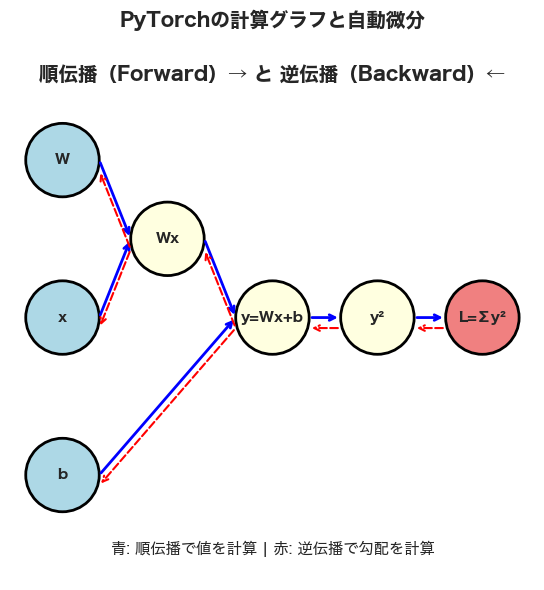

💡 ポイント:
  1. 順伝播: 入力から出力へ値を計算
  2. 逆伝播: 出力から入力へ勾配を計算（連鎖律）
  3. PyTorchはこれを自動的に行う（Autograd）


In [8]:
# ============================================================
# 計算グラフの可視化
# 自動微分の仕組みを図で理解します
# ============================================================

fig, ax = plt.subplots(figsize=(12, 6))

# ノードの位置
nodes = {
    'x': (0.1, 0.5),
    'W': (0.1, 0.8),
    'b': (0.1, 0.2),
    'Wx': (0.3, 0.65),
    'y=Wx+b': (0.5, 0.5),
    'y²': (0.7, 0.5),
    'L=Σy²': (0.9, 0.5),
}

# ノードを描画
for name, (x, y) in nodes.items():
    if name in ['x', 'W', 'b']:
        color = 'lightblue'
    elif name == 'L=Σy²':
        color = 'lightcoral'
    else:
        color = 'lightyellow'
    
    circle = plt.Circle((x, y), 0.07, color=color, ec='black', linewidth=2)
    ax.add_patch(circle)
    ax.text(x, y, name, ha='center', va='center', fontsize=10, fontweight='bold')

# エッジ（順伝播）
edges_forward = [
    ('x', 'Wx'),
    ('W', 'Wx'),
    ('Wx', 'y=Wx+b'),
    ('b', 'y=Wx+b'),
    ('y=Wx+b', 'y²'),
    ('y²', 'L=Σy²'),
]

for start, end in edges_forward:
    x1, y1 = nodes[start]
    x2, y2 = nodes[end]
    ax.annotate('', xy=(x2-0.07, y2), xytext=(x1+0.07, y1),
                arrowprops=dict(arrowstyle='->', color='blue', lw=2))

# 凡例
ax.text(0.5, 0.95, '順伝播（Forward）→ と 逆伝播（Backward）←', 
        ha='center', fontsize=14, fontweight='bold', transform=ax.transAxes)
ax.text(0.5, 0.05, '青: 順伝播で値を計算 | 赤: 逆伝播で勾配を計算', 
        ha='center', fontsize=11, transform=ax.transAxes)

# 逆伝播の矢印（点線）
for start, end in reversed(edges_forward):
    x1, y1 = nodes[start]
    x2, y2 = nodes[end]
    ax.annotate('', xy=(x1+0.07, y1-0.02), xytext=(x2-0.07, y2-0.02),
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5, ls='--'))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('PyTorchの計算グラフと自動微分', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("💡 ポイント:")
print("  1. 順伝播: 入力から出力へ値を計算")
print("  2. 逆伝播: 出力から入力へ勾配を計算（連鎖律）")
print("  3. PyTorchはこれを自動的に行う（Autograd）")

---

## 3. 勾配降下法の実装

### 🤔 勾配降下法とは？

**勾配降下法（Gradient Descent）**は、損失関数を最小化するためのアルゴリズムです。

$$\theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} L(\theta^{(t)})$$

- $\theta$: パラメータ
- $\eta$: 学習率（learning rate）
- $L$: 損失関数
- $\nabla_{\theta} L$: 損失関数のパラメータに関する勾配

### 📊 EMアルゴリズムとの関係

| 手法 | 最適化対象 | 更新方法 |
|------|----------|----------|
| EMアルゴリズム | ELBO | 解析的な更新式 |
| 勾配降下法 | 損失関数 | 勾配による反復更新 |
| VAE | ELBO | 勾配降下法で最適化 |

In [9]:
# ============================================================
# 勾配降下法の手動実装
# 簡単な2次関数の最小化を行います
# ============================================================

print("="*60)
print("勾配降下法の手動実装")
print("="*60)

# 問題: f(x) = (x - 3)^2 を最小化
# 最適解は x = 3

def f(x):
    return (x - 3) ** 2

# 初期値
x = torch.tensor(0.0, requires_grad=True)
learning_rate = 0.1

# 履歴を保存
history = {'x': [x.item()], 'f': [f(x).item()]}

print(f"\n目標: f(x) = (x - 3)² の最小化")
print(f"最適解: x = 3")
print(f"初期値: x = {x.item()}")
print(f"学習率: η = {learning_rate}")
print("\n" + "-"*40)

# 勾配降下法
for step in range(20):
    # 順伝播
    loss = f(x)
    
    # 勾配をリセット
    if x.grad is not None:
        x.grad.zero_()
    
    # 逆伝播
    loss.backward()
    
    # パラメータ更新（勾配降下）
    with torch.no_grad():
        x -= learning_rate * x.grad
    
    # 履歴を保存
    history['x'].append(x.item())
    history['f'].append(f(x).item())
    
    if step < 5 or step >= 18:
        print(f"Step {step+1:2d}: x = {x.item():7.4f}, f(x) = {f(x).item():7.4f}")
    elif step == 5:
        print("  ...")

print("-"*40)
print(f"最終結果: x = {x.item():.4f}（期待値: 3.0）")

勾配降下法の手動実装

目標: f(x) = (x - 3)² の最小化
最適解: x = 3
初期値: x = 0.0
学習率: η = 0.1

----------------------------------------
Step  1: x =  0.6000, f(x) =  5.7600
Step  2: x =  1.0800, f(x) =  3.6864
Step  3: x =  1.4640, f(x) =  2.3593
Step  4: x =  1.7712, f(x) =  1.5099
Step  5: x =  2.0170, f(x) =  0.9664
  ...
Step 19: x =  2.9568, f(x) =  0.0019
Step 20: x =  2.9654, f(x) =  0.0012
----------------------------------------
最終結果: x = 2.9654（期待値: 3.0）


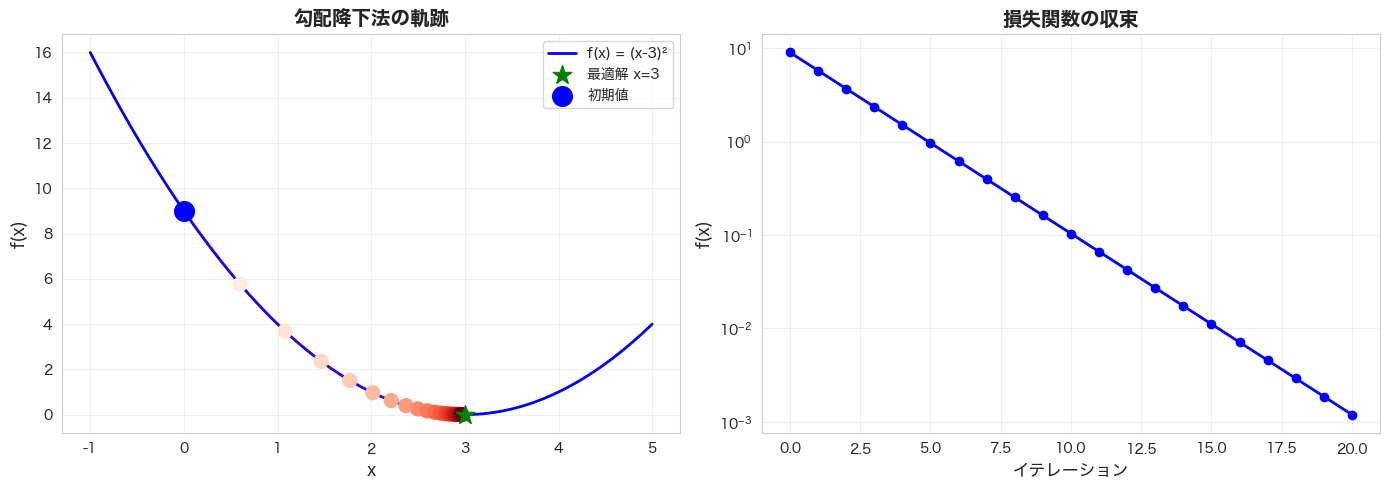

In [10]:
# ============================================================
# 勾配降下法の可視化
# 収束の様子をアニメーション風に表示します
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 関数と最適化の軌跡
ax = axes[0]
x_range = np.linspace(-1, 5, 100)
y_range = (x_range - 3) ** 2

ax.plot(x_range, y_range, 'b-', linewidth=2, label='f(x) = (x-3)²')
ax.scatter(history['x'], history['f'], c=range(len(history['x'])), cmap='Reds', s=100, zorder=5)
ax.plot(history['x'], history['f'], 'r--', alpha=0.5, linewidth=1)
ax.scatter([3], [0], c='green', s=200, marker='*', zorder=10, label='最適解 x=3')
ax.scatter([history['x'][0]], [history['f'][0]], c='blue', s=200, marker='o', zorder=10, label='初期値')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('f(x)', fontsize=12)
ax.set_title('勾配降下法の軌跡', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 右: 収束曲線
ax = axes[1]
ax.plot(history['f'], 'bo-', linewidth=2, markersize=6)
ax.set_xlabel('イテレーション', fontsize=12)
ax.set_ylabel('f(x)', fontsize=12)
ax.set_title('損失関数の収束', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# ============================================================
# PyTorchのオプティマイザを使用
# torch.optimの使い方を学びます
# ============================================================

print("="*60)
print("PyTorchオプティマイザの使用")
print("="*60)

# 同じ問題をオプティマイザで解く
x = torch.tensor(0.0, requires_grad=True)

# オプティマイザを作成
optimizer = optim.SGD([x], lr=0.1)

print(f"\nオプティマイザ: SGD (Stochastic Gradient Descent)")
print(f"学習率: 0.1")
print("\n" + "-"*40)

for step in range(20):
    # 勾配をリセット
    optimizer.zero_grad()
    
    # 順伝播
    loss = (x - 3) ** 2
    
    # 逆伝播
    loss.backward()
    
    # パラメータ更新
    optimizer.step()
    
    if step < 3 or step >= 18:
        print(f"Step {step+1:2d}: x = {x.item():7.4f}, loss = {loss.item():7.4f}")
    elif step == 3:
        print("  ...")

print("-"*40)
print(f"最終結果: x = {x.item():.4f}")

print("\n💡 オプティマイザの使い方:")
print("  1. optimizer.zero_grad()  # 勾配をリセット")
print("  2. loss.backward()        # 勾配を計算")
print("  3. optimizer.step()       # パラメータを更新")

PyTorchオプティマイザの使用

オプティマイザ: SGD (Stochastic Gradient Descent)
学習率: 0.1

----------------------------------------
Step  1: x =  0.6000, loss =  9.0000
Step  2: x =  1.0800, loss =  5.7600
Step  3: x =  1.4640, loss =  3.6864
  ...
Step 19: x =  2.9568, loss =  0.0029
Step 20: x =  2.9654, loss =  0.0019
----------------------------------------
最終結果: x = 2.9654

💡 オプティマイザの使い方:
  1. optimizer.zero_grad()  # 勾配をリセット
  2. loss.backward()        # 勾配を計算
  3. optimizer.step()       # パラメータを更新


---

## 4. ニューラルネットワークの構築

### 🤔 nn.Module とは？

PyTorchでニューラルネットワークを構築するには、`nn.Module`を継承したクラスを作成します。

### 📊 基本構造

```python
class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 層を定義
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # 順伝播を定義
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
```

In [12]:
# ============================================================
# 簡単なニューラルネットワーク
# 2入力1出力のネットワークを構築します
# ============================================================

print("="*60)
print("簡単なニューラルネットワーク")
print("="*60)

class SimpleNetwork(nn.Module):
    """2層のニューラルネットワーク"""
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # 層を定義
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # 順伝播を定義
        x = F.relu(self.fc1(x))  # 隠れ層 + ReLU活性化
        x = self.fc2(x)           # 出力層
        return x

# ネットワークを作成
model = SimpleNetwork(input_dim=2, hidden_dim=10, output_dim=1)
print(model)

# パラメータ数を確認
total_params = sum(p.numel() for p in model.parameters())
print(f"\n総パラメータ数: {total_params}")

# 各層のパラメータ
for name, param in model.named_parameters():
    print(f"  {name}: {param.shape}")

簡単なニューラルネットワーク
SimpleNetwork(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)

総パラメータ数: 41
  fc1.weight: torch.Size([10, 2])
  fc1.bias: torch.Size([10])
  fc2.weight: torch.Size([1, 10])
  fc2.bias: torch.Size([1])


In [13]:
# ============================================================
# 回帰問題での学習
# ニューラルネットワークで関数近似を行います
# ============================================================

print("="*60)
print("回帰問題での学習")
print("="*60)

# データを生成: y = sin(x1) + cos(x2) + noise
np.random.seed(42)
n_samples = 500

X_np = np.random.randn(n_samples, 2).astype(np.float32)
y_np = (np.sin(X_np[:, 0]) + np.cos(X_np[:, 1]) + 0.1 * np.random.randn(n_samples)).astype(np.float32)

# PyTorchテンソルに変換
X = torch.from_numpy(X_np)
y = torch.from_numpy(y_np).unsqueeze(1)  # (N,) -> (N, 1)

print(f"X.shape = {X.shape}")
print(f"y.shape = {y.shape}")

# データセットとデータローダーを作成
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"\nバッチ数: {len(dataloader)}")
print(f"バッチサイズ: 32")

回帰問題での学習
X.shape = torch.Size([500, 2])
y.shape = torch.Size([500, 1])

バッチ数: 16
バッチサイズ: 32


In [14]:
# ============================================================
# 学習ループの実装
# ミニバッチ勾配降下法でモデルを学習します
# ============================================================

# モデルを初期化
model = SimpleNetwork(input_dim=2, hidden_dim=32, output_dim=1)

# 損失関数とオプティマイザ
criterion = nn.MSELoss()  # 平均二乗誤差
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 学習履歴
train_losses = []

# 学習ループ
n_epochs = 100

print("学習開始...")
print("-"*40)

for epoch in range(n_epochs):
    epoch_loss = 0.0
    
    for batch_X, batch_y in dataloader:
        # 勾配をリセット
        optimizer.zero_grad()
        
        # 順伝播
        pred = model(batch_X)
        
        # 損失を計算
        loss = criterion(pred, batch_y)
        
        # 逆伝播
        loss.backward()
        
        # パラメータ更新
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # エポックごとの平均損失
    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d}/{n_epochs}: Loss = {avg_loss:.4f}")

print("-"*40)
print("学習完了！")

学習開始...
----------------------------------------
Epoch  20/100: Loss = 0.0221
Epoch  40/100: Loss = 0.0146
Epoch  60/100: Loss = 0.0126
Epoch  80/100: Loss = 0.0129
Epoch 100/100: Loss = 0.0130
----------------------------------------
学習完了！


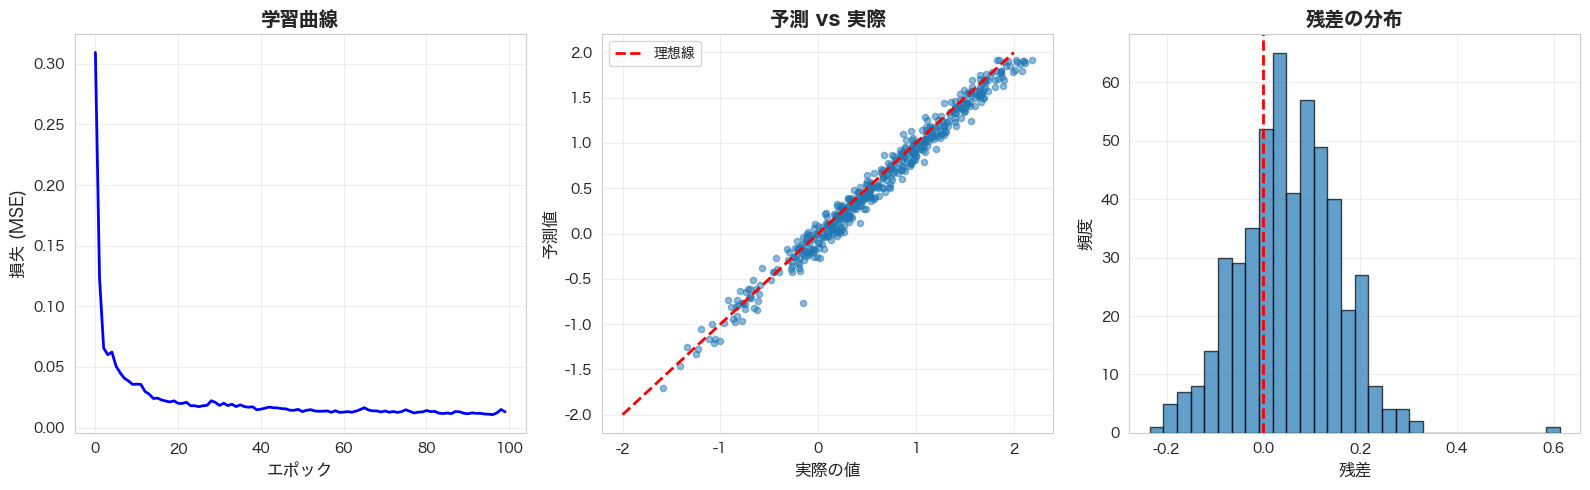


評価指標:
  MSE = 0.0131
  R² = 0.9821


In [15]:
# ============================================================
# 学習結果の可視化
# 損失曲線と予測結果を表示します
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 左: 損失曲線
ax = axes[0]
ax.plot(train_losses, 'b-', linewidth=2)
ax.set_xlabel('エポック', fontsize=12)
ax.set_ylabel('損失 (MSE)', fontsize=12)
ax.set_title('学習曲線', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# 中央: 予測 vs 実際
ax = axes[1]
with torch.no_grad():
    y_pred = model(X).numpy()

ax.scatter(y.numpy(), y_pred, alpha=0.5, s=20)
ax.plot([-2, 2], [-2, 2], 'r--', linewidth=2, label='理想線')
ax.set_xlabel('実際の値', fontsize=12)
ax.set_ylabel('予測値', fontsize=12)
ax.set_title('予測 vs 実際', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 右: 残差の分布
ax = axes[2]
residuals = y.numpy().flatten() - y_pred.flatten()
ax.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('残差', fontsize=12)
ax.set_ylabel('頻度', fontsize=12)
ax.set_title('残差の分布', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 評価指標
mse = np.mean(residuals ** 2)
r2 = 1 - np.var(residuals) / np.var(y.numpy())
print(f"\n評価指標:")
print(f"  MSE = {mse:.4f}")
print(f"  R² = {r2:.4f}")

---

## 5. VAE実装への準備

### 📊 VAEに必要な要素

VAEを実装するには、以下の要素が必要です：

1. **エンコーダ**: 入力を潜在空間にマッピング
2. **デコーダ**: 潜在変数から入力を再構成
3. **再パラメータ化トリック**: 勾配を通すための工夫
4. **損失関数**: 再構成誤差 + KLダイバージェンス

以下では、これらの要素を個別に実装してみましょう。

In [16]:
# ============================================================
# エンコーダの実装
# 入力から潜在変数の平均と分散を出力します
# ============================================================

print("="*60)
print("エンコーダの実装")
print("="*60)

class Encoder(nn.Module):
    """VAEのエンコーダ: 入力 → (μ, log σ²)"""
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)      # 平均
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # 対数分散
    
    def forward(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# テスト
encoder = Encoder(input_dim=784, hidden_dim=256, latent_dim=2)
print(encoder)

# ダミー入力でテスト
x_dummy = torch.randn(5, 784)  # バッチサイズ5、入力次元784
mu, logvar = encoder(x_dummy)

print(f"\n入力: {x_dummy.shape}")
print(f"出力 μ: {mu.shape}")
print(f"出力 log σ²: {logvar.shape}")

エンコーダの実装
Encoder(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=2, bias=True)
)

入力: torch.Size([5, 784])
出力 μ: torch.Size([5, 2])
出力 log σ²: torch.Size([5, 2])


In [17]:
# ============================================================
# 再パラメータ化トリック
# 勾配を通すための重要なテクニック
# ============================================================

print("="*60)
print("再パラメータ化トリック（Reparameterization Trick）")
print("="*60)

def reparameterize(mu, logvar):
    """
    再パラメータ化トリック
    
    z = μ + σ * ε, where ε ~ N(0, I)
    
    これにより、確率的なサンプリングを通じて勾配を伝播できる
    """
    std = torch.exp(0.5 * logvar)  # σ = exp(0.5 * log σ²)
    eps = torch.randn_like(std)     # ε ~ N(0, I)
    z = mu + std * eps
    return z

# テスト
z = reparameterize(mu, logvar)
print(f"μ: {mu.shape}")
print(f"log σ²: {logvar.shape}")
print(f"z: {z.shape}")

print("\n💡 なぜ再パラメータ化トリックが必要か？")
print("  ❌ z ~ N(μ, σ²) からサンプリング → 勾配が通らない")
print("  ✅ z = μ + σ * ε (ε ~ N(0,1)) → 勾配が μ, σ に通る")

再パラメータ化トリック（Reparameterization Trick）
μ: torch.Size([5, 2])
log σ²: torch.Size([5, 2])
z: torch.Size([5, 2])

💡 なぜ再パラメータ化トリックが必要か？
  ❌ z ~ N(μ, σ²) からサンプリング → 勾配が通らない
  ✅ z = μ + σ * ε (ε ~ N(0,1)) → 勾配が μ, σ に通る


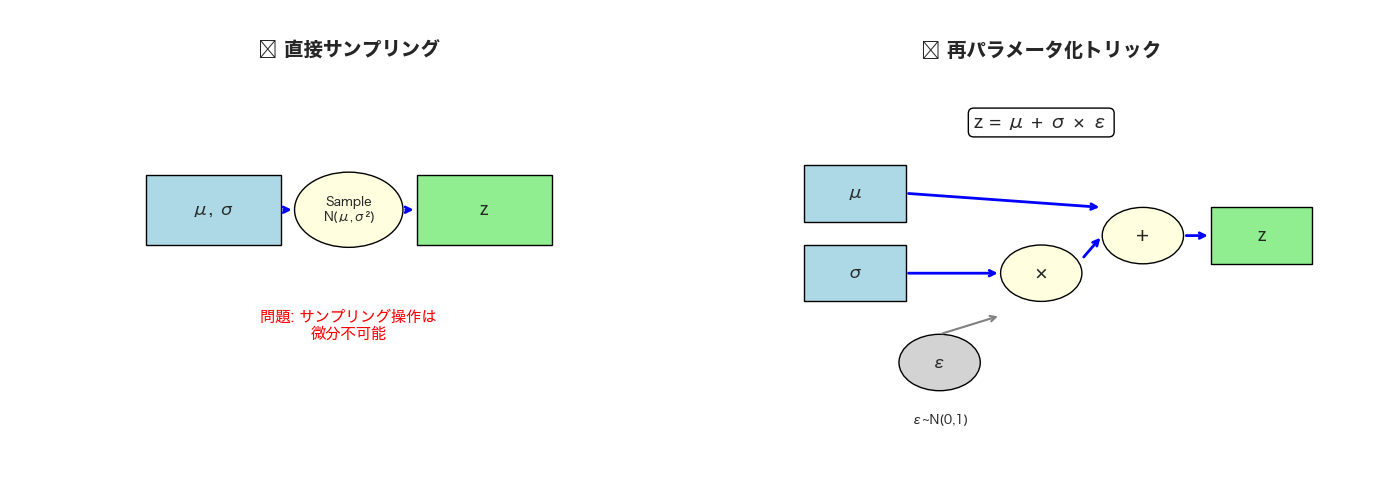

In [18]:
# ============================================================
# 再パラメータ化トリックの可視化
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 直接サンプリング（勾配が通らない）
ax = axes[0]
ax.text(0.5, 0.9, '❌ 直接サンプリング', ha='center', fontsize=14, fontweight='bold', transform=ax.transAxes)

# ノード
ax.add_patch(plt.Rectangle((0.2, 0.5), 0.2, 0.15, color='lightblue', ec='black'))
ax.text(0.3, 0.575, 'μ, σ', ha='center', va='center', fontsize=12)

ax.add_patch(plt.Circle((0.5, 0.575), 0.08, color='lightyellow', ec='black'))
ax.text(0.5, 0.575, 'Sample\nN(μ,σ²)', ha='center', va='center', fontsize=9)

ax.add_patch(plt.Rectangle((0.6, 0.5), 0.2, 0.15, color='lightgreen', ec='black'))
ax.text(0.7, 0.575, 'z', ha='center', va='center', fontsize=12)

ax.annotate('', xy=(0.42, 0.575), xytext=(0.4, 0.575),
            arrowprops=dict(arrowstyle='->', color='blue', lw=2))
ax.annotate('', xy=(0.6, 0.575), xytext=(0.58, 0.575),
            arrowprops=dict(arrowstyle='->', color='blue', lw=2))

ax.text(0.5, 0.3, '問題: サンプリング操作は\n微分不可能', ha='center', fontsize=11, color='red')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# 右: 再パラメータ化トリック（勾配が通る）
ax = axes[1]
ax.text(0.5, 0.9, '✅ 再パラメータ化トリック', ha='center', fontsize=14, fontweight='bold', transform=ax.transAxes)

# ノード
ax.add_patch(plt.Rectangle((0.15, 0.55), 0.15, 0.12, color='lightblue', ec='black'))
ax.text(0.225, 0.61, 'μ', ha='center', va='center', fontsize=12)

ax.add_patch(plt.Rectangle((0.15, 0.38), 0.15, 0.12, color='lightblue', ec='black'))
ax.text(0.225, 0.44, 'σ', ha='center', va='center', fontsize=12)

ax.add_patch(plt.Circle((0.35, 0.25), 0.06, color='lightgray', ec='black'))
ax.text(0.35, 0.25, 'ε', ha='center', va='center', fontsize=12)
ax.text(0.35, 0.12, 'ε~N(0,1)', ha='center', fontsize=9)

ax.add_patch(plt.Circle((0.5, 0.44), 0.06, color='lightyellow', ec='black'))
ax.text(0.5, 0.44, '×', ha='center', va='center', fontsize=14)

ax.add_patch(plt.Circle((0.65, 0.52), 0.06, color='lightyellow', ec='black'))
ax.text(0.65, 0.52, '+', ha='center', va='center', fontsize=14)

ax.add_patch(plt.Rectangle((0.75, 0.46), 0.15, 0.12, color='lightgreen', ec='black'))
ax.text(0.825, 0.52, 'z', ha='center', va='center', fontsize=12)

# 矢印
ax.annotate('', xy=(0.44, 0.44), xytext=(0.3, 0.44), arrowprops=dict(arrowstyle='->', color='blue', lw=2))
ax.annotate('', xy=(0.44, 0.35), xytext=(0.35, 0.31), arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))
ax.annotate('', xy=(0.59, 0.52), xytext=(0.56, 0.47), arrowprops=dict(arrowstyle='->', color='blue', lw=2))
ax.annotate('', xy=(0.59, 0.58), xytext=(0.3, 0.61), arrowprops=dict(arrowstyle='->', color='blue', lw=2))
ax.annotate('', xy=(0.75, 0.52), xytext=(0.71, 0.52), arrowprops=dict(arrowstyle='->', color='blue', lw=2))

ax.text(0.5, 0.75, 'z = μ + σ × ε', ha='center', fontsize=13, 
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

plt.tight_layout()
plt.show()

In [19]:
# ============================================================
# デコーダの実装
# 潜在変数から入力を再構成します
# ============================================================

print("="*60)
print("デコーダの実装")
print("="*60)

class Decoder(nn.Module):
    """VAEのデコーダ: 潜在変数 → 再構成"""
    
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h))  # 出力を[0,1]に正規化
        return x_recon

# テスト
decoder = Decoder(latent_dim=2, hidden_dim=256, output_dim=784)
print(decoder)

# 潜在変数から再構成
x_recon = decoder(z)
print(f"\n潜在変数 z: {z.shape}")
print(f"再構成 x: {x_recon.shape}")

デコーダの実装
Decoder(
  (fc1): Linear(in_features=2, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=784, bias=True)
)

潜在変数 z: torch.Size([5, 2])
再構成 x: torch.Size([5, 784])


In [20]:
# ============================================================
# VAEの損失関数
# 再構成誤差 + KLダイバージェンス
# ============================================================

print("="*60)
print("VAEの損失関数")
print("="*60)

def vae_loss(x, x_recon, mu, logvar):
    """
    VAEの損失関数 = -ELBO
    
    L = 再構成誤差 + KLダイバージェンス
    
    再構成誤差: -E[log p(x|z)] ≈ BCE または MSE
    KLダイバージェンス: D_KL(q(z|x) || p(z))
                      = -0.5 * Σ(1 + log σ² - μ² - σ²)
    """
    # 再構成誤差（Binary Cross Entropy）
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
    
    # KLダイバージェンス
    # D_KL(N(μ, σ²) || N(0, 1)) = -0.5 * Σ(1 + log σ² - μ² - σ²)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_loss, recon_loss, kl_loss

# テスト
x_dummy = torch.rand(5, 784)  # 元の入力（0-1に正規化）
total_loss, recon, kl = vae_loss(x_dummy, x_recon, mu, logvar)

print(f"再構成誤差: {recon.item():.2f}")
print(f"KLダイバージェンス: {kl.item():.2f}")
print(f"総損失: {total_loss.item():.2f}")

print("\n💡 損失関数の意味:")
print("  再構成誤差: 入力をどれだけ正確に再現できるか")
print("  KL損失: 潜在空間がN(0,1)にどれだけ近いか")

VAEの損失関数
再構成誤差: 2747.21
KLダイバージェンス: 0.45
総損失: 2747.66

💡 損失関数の意味:
  再構成誤差: 入力をどれだけ正確に再現できるか
  KL損失: 潜在空間がN(0,1)にどれだけ近いか


---

## まとめ

### 🎯 このノートブックで学んだこと

**テンソル操作**
- ✓ テンソルの作成と基本演算
- ✓ 形状変更（view, reshape, squeeze, unsqueeze）
- ✓ NumPyとの相互変換

**自動微分（Autograd）**
- ✓ `requires_grad=True`で勾配追跡を有効化
- ✓ `backward()`で勾配を自動計算
- ✓ 計算グラフと連鎖律

**勾配降下法**
- ✓ 手動での実装方法
- ✓ `torch.optim`の使い方
- ✓ SGD, Adamなどのオプティマイザ

**ニューラルネットワーク**
- ✓ `nn.Module`の構造
- ✓ 層の定義と順伝播
- ✓ 学習ループの実装

**VAE実装の準備**
- ✓ エンコーダ: 入力 → (μ, log σ²)
- ✓ 再パラメータ化トリック: z = μ + σ * ε
- ✓ デコーダ: z → 再構成
- ✓ 損失関数: 再構成誤差 + KL損失

### 📊 PyTorchチートシート

| 操作 | コード |
|------|--------|
| テンソル作成 | `torch.tensor([1,2,3])` |
| ゼロ行列 | `torch.zeros(3, 4)` |
| 乱数 | `torch.randn(3, 4)` |
| 形状変更 | `x.view(2, -1)` |
| 次元追加 | `x.unsqueeze(0)` |
| 勾配有効化 | `requires_grad=True` |
| 逆伝播 | `loss.backward()` |
| 勾配リセット | `optimizer.zero_grad()` |
| 更新 | `optimizer.step()` |

---

## 🎓 自己評価クイズ

### Q1: `requires_grad=True`の役割は何ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: テンソルに対する演算の計算グラフを記録し、勾配を自動計算できるようにする

`requires_grad=True`を設定すると、そのテンソルを使った演算が記録され、`backward()`を呼び出すと連鎖律を使って勾配が自動計算されます。

</details>

---

### Q2: 再パラメータ化トリックはなぜ必要ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: サンプリング操作を通じて勾配を伝播するため

通常のサンプリング z ~ N(μ, σ²) は微分不可能ですが、z = μ + σ * ε（ε ~ N(0,1)）と書き換えると、zはμとσの決定論的な関数となり、勾配を計算できます。

</details>

---

### Q3: VAEの損失関数の2つの項は何を表していますか？

<details>
<summary>💡 答えを見る</summary>

**答え**:

1. **再構成誤差**: 入力をどれだけ正確に再現できるか
   - デコーダの性能を評価
   - BCE（二値）またはMSE（連続）

2. **KLダイバージェンス**: 潜在空間の正則化
   - q(z|x)がp(z)=N(0,1)に近いか
   - 潜在空間を滑らかにする効果

</details>

---

### Q4: PyTorchの学習ループの3ステップを説明してください

<details>
<summary>💡 答えを見る</summary>

**答え**:

```python
# 1. 勾配をリセット
optimizer.zero_grad()

# 2. 損失を計算して逆伝播
loss = criterion(pred, target)
loss.backward()

# 3. パラメータを更新
optimizer.step()
```

重要: `zero_grad()`を忘れると、勾配が蓄積されてしまいます。

</details>

---

### ✅ 学習チェックリスト

- [ ] テンソルの基本操作ができる
- [ ] 自動微分の仕組みを説明できる
- [ ] 勾配降下法を実装できる
- [ ] nn.Moduleでネットワークを構築できる
- [ ] 再パラメータ化トリックを説明できる
- [ ] VAEの損失関数を実装できる

---

**次のステップ**: Notebook 36で、**VAE（変分オートエンコーダ）**を完全実装します！

ここで学んだ要素を組み合わせて、MNISTデータセットで画像生成を行います。